In [8]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ML

In [10]:
## PCA 주성분 개수
n = 2

In [11]:
df = pd.read_csv("heart_disease.csv")

# Alzheimer’s Diagnosis를 종속 변수(y)로 설정
y_col = "target"
y = df[y_col]

# 독립 변수 설정
X = df.drop(columns=[y_col])

# 연속형 변수와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns

## PCA 적용 전 정규화 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[continuous_vars])

# PCA 적용
pca = PCA(n_components=n)
principal_components = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(principal_components, columns=['PCA_1', 'PCA_2'])
df = pd.concat([df, df_pca], axis=1)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [13]:
# Heart Disease를 종속 변수(y)로 설정
y_col = "target"
y = df[y_col]

# 독립 변수(X) 설정 (Patient_ID 제거)
X = df.drop(columns=[y_col])

# 연속형 변수 (float, int)와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_vars = X.select_dtypes(include=["object"]).columns.tolist()

In [14]:
df_encoded = pd.get_dummies(df, columns=categorical_vars)
X = df_encoded.drop(columns=y_col)

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model

### Logistic Regression

In [16]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.8689


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.8361


### Decision Tree

In [18]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 5}
Accuracy: 0.8360655737704918
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



### XGBoost

In [19]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

🔹 XGBoost Classifier Results:
Accuracy: 0.8360655737704918
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:11:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### LightGBM

In [20]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

### CatBoost

In [21]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.8360655737704918
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



# DL

In [22]:
## PCA 주성분 개수
n = 2

In [23]:
df = pd.read_csv("heart_disease.csv")

# Alzheimer’s Diagnosis를 종속 변수(y)로 설정
y_col = "target"
y = df[y_col]

# 독립 변수 설정
X = df.drop(columns=[y_col])

# 연속형 변수와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns

## PCA 적용 전 정규화 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[continuous_vars])

# PCA 적용
pca = PCA(n_components=n)
principal_components = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(principal_components, columns=['PCA_1', 'PCA_2'])
df = pd.concat([df, df_pca], axis=1)

In [24]:
# 분류 task
is_classification = True

In [25]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={"age" : numerical,
              "sex" : categorical,
              "cp" : numerical,
              "trestbps" : numerical,
              "chol" : numerical,
              "fbs" : categorical,
              "restecg" : numerical,
              "thalach" : numerical,
              "exang" : categorical,
              "oldpeak" : numerical,
              "slope" : categorical,
              "ca" : numerical,
              "thal" : numerical,
              "target" : categorical}

dataset = Dataset(df=df, 
                  col_to_stype=col_to_stype, 
                  target_col='target')

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [26]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [27]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [28]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [29]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}
    
    # 모델 초기화
    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)
    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 1, Epoch 1: Train Loss: 0.8049, Train Acc: 0.7025, Val Acc: 0.7541


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s]


Fold 1, Epoch 2: Train Loss: 0.6651, Train Acc: 0.7355, Val Acc: 0.7541


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 103.30it/s]


Fold 1, Epoch 3: Train Loss: 0.5782, Train Acc: 0.7769, Val Acc: 0.8033


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 93.49it/s]


Fold 1, Epoch 4: Train Loss: 0.5302, Train Acc: 0.7727, Val Acc: 0.8033


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 90.11it/s]


Fold 1, Epoch 5: Train Loss: 0.5269, Train Acc: 0.7686, Val Acc: 0.8033


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 85.09it/s]


Fold 1, Epoch 6: Train Loss: 0.5076, Train Acc: 0.7686, Val Acc: 0.8033


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 87.32it/s]


Fold 1, Epoch 7: Train Loss: 0.5134, Train Acc: 0.7686, Val Acc: 0.8033


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 80.74it/s]


Fold 1, Epoch 8: Train Loss: 0.4933, Train Acc: 0.7686, Val Acc: 0.8033


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 82.81it/s]


Fold 1, Epoch 9: Train Loss: 0.5327, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 87.73it/s]


Fold 1, Epoch 10: Train Loss: 0.4924, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 80.04it/s]


Fold 1, Epoch 11: Train Loss: 0.4973, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 79.62it/s]


Fold 1, Epoch 12: Train Loss: 0.4993, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 82.91it/s]


Fold 1, Epoch 13: Train Loss: 0.4968, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 80.48it/s]


Fold 1, Epoch 14: Train Loss: 0.5025, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 87.75it/s]


Fold 1, Epoch 15: Train Loss: 0.4962, Train Acc: 0.7810, Val Acc: 0.8033
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 92.93it/s]


Fold 2, Epoch 1: Train Loss: 0.6745, Train Acc: 0.7314, Val Acc: 0.6066


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 120.36it/s]


Fold 2, Epoch 2: Train Loss: 0.5801, Train Acc: 0.8306, Val Acc: 0.6721


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 136.05it/s]


Fold 2, Epoch 3: Train Loss: 0.5268, Train Acc: 0.7975, Val Acc: 0.6885


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 142.66it/s]


Fold 2, Epoch 4: Train Loss: 0.4912, Train Acc: 0.7975, Val Acc: 0.6557


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 140.19it/s]


Fold 2, Epoch 5: Train Loss: 0.4745, Train Acc: 0.7975, Val Acc: 0.6557


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 144.17it/s]


Fold 2, Epoch 6: Train Loss: 0.4687, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 148.51it/s]


Fold 2, Epoch 7: Train Loss: 0.4819, Train Acc: 0.8017, Val Acc: 0.6393


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 148.50it/s]


Fold 2, Epoch 8: Train Loss: 0.4541, Train Acc: 0.8140, Val Acc: 0.6557


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 147.00it/s]


Fold 2, Epoch 9: Train Loss: 0.4718, Train Acc: 0.8099, Val Acc: 0.6721


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 147.34it/s]


Fold 2, Epoch 10: Train Loss: 0.4577, Train Acc: 0.8099, Val Acc: 0.6557


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 145.63it/s]


Fold 2, Epoch 11: Train Loss: 0.4369, Train Acc: 0.8099, Val Acc: 0.6393


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 145.05it/s]


Fold 2, Epoch 12: Train Loss: 0.4389, Train Acc: 0.8099, Val Acc: 0.6393


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 146.79it/s]


Fold 2, Epoch 13: Train Loss: 0.4510, Train Acc: 0.8099, Val Acc: 0.6393


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 149.93it/s]


Fold 2, Epoch 14: Train Loss: 0.4352, Train Acc: 0.8099, Val Acc: 0.6393


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 147.92it/s]


Fold 2, Epoch 15: Train Loss: 0.4643, Train Acc: 0.8099, Val Acc: 0.6557
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 113.53it/s]


Fold 3, Epoch 1: Train Loss: 0.6696, Train Acc: 0.7686, Val Acc: 0.7705


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 144.51it/s]


Fold 3, Epoch 2: Train Loss: 0.5966, Train Acc: 0.7893, Val Acc: 0.7705


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 144.82it/s]


Fold 3, Epoch 3: Train Loss: 0.5514, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 111.33it/s]


Fold 3, Epoch 4: Train Loss: 0.5192, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 137.94it/s]


Fold 3, Epoch 5: Train Loss: 0.5085, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]


Fold 3, Epoch 6: Train Loss: 0.5103, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 144.91it/s]


Fold 3, Epoch 7: Train Loss: 0.5072, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 134.54it/s]


Fold 3, Epoch 8: Train Loss: 0.4973, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 124.36it/s]


Fold 3, Epoch 9: Train Loss: 0.5122, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 107.67it/s]


Fold 3, Epoch 10: Train Loss: 0.5009, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 82.42it/s]


Fold 3, Epoch 11: Train Loss: 0.4920, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 94.11it/s]


Fold 3, Epoch 12: Train Loss: 0.5128, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 131.43it/s]


Fold 3, Epoch 13: Train Loss: 0.4995, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 135.48it/s]


Fold 3, Epoch 14: Train Loss: 0.4717, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 77.05it/s]


Fold 3, Epoch 15: Train Loss: 0.4894, Train Acc: 0.7851, Val Acc: 0.7705
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 82.15it/s]


Fold 4, Epoch 1: Train Loss: 0.7399, Train Acc: 0.6872, Val Acc: 0.6833


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 74.82it/s]


Fold 4, Epoch 2: Train Loss: 0.6079, Train Acc: 0.7490, Val Acc: 0.8167


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 94.85it/s]


Fold 4, Epoch 3: Train Loss: 0.5907, Train Acc: 0.7613, Val Acc: 0.8167


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 96.01it/s]


Fold 4, Epoch 4: Train Loss: 0.5187, Train Acc: 0.7654, Val Acc: 0.8333


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 112.36it/s]


Fold 4, Epoch 5: Train Loss: 0.5184, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 149.65it/s]


Fold 4, Epoch 6: Train Loss: 0.5139, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 184.38it/s]


Fold 4, Epoch 7: Train Loss: 0.5308, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 187.22it/s]


Fold 4, Epoch 8: Train Loss: 0.5094, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 186.64it/s]


Fold 4, Epoch 9: Train Loss: 0.5225, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 184.63it/s]


Fold 4, Epoch 10: Train Loss: 0.5008, Train Acc: 0.7613, Val Acc: 0.8167


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 187.11it/s]


Fold 4, Epoch 11: Train Loss: 0.5413, Train Acc: 0.7654, Val Acc: 0.8167


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 190.19it/s]


Fold 4, Epoch 12: Train Loss: 0.5153, Train Acc: 0.7654, Val Acc: 0.8167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 188.41it/s]


Fold 4, Epoch 13: Train Loss: 0.5087, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 190.28it/s]


Fold 4, Epoch 14: Train Loss: 0.4876, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 185.66it/s]


Fold 4, Epoch 15: Train Loss: 0.5163, Train Acc: 0.7737, Val Acc: 0.8167
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 155.67it/s]


Fold 5, Epoch 1: Train Loss: 0.7056, Train Acc: 0.6914, Val Acc: 0.6833


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 156.60it/s]


Fold 5, Epoch 2: Train Loss: 0.6407, Train Acc: 0.7654, Val Acc: 0.7667


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 156.91it/s]


Fold 5, Epoch 3: Train Loss: 0.5488, Train Acc: 0.7778, Val Acc: 0.7667


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 174.92it/s]


Fold 5, Epoch 4: Train Loss: 0.5277, Train Acc: 0.7778, Val Acc: 0.8167


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 156.85it/s]


Fold 5, Epoch 5: Train Loss: 0.4971, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 168.26it/s]


Fold 5, Epoch 6: Train Loss: 0.5204, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 141.45it/s]


Fold 5, Epoch 7: Train Loss: 0.5035, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 141.37it/s]


Fold 5, Epoch 8: Train Loss: 0.5053, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 143.58it/s]


Fold 5, Epoch 9: Train Loss: 0.4925, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 131.76it/s]


Fold 5, Epoch 10: Train Loss: 0.5038, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 73.37it/s]


Fold 5, Epoch 11: Train Loss: 0.4930, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 185.96it/s]


Fold 5, Epoch 12: Train Loss: 0.4979, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 156.66it/s]


Fold 5, Epoch 13: Train Loss: 0.4986, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 153.42it/s]


Fold 5, Epoch 14: Train Loss: 0.4852, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 133.19it/s]


Fold 5, Epoch 15: Train Loss: 0.4865, Train Acc: 0.7695, Val Acc: 0.8333
Final Best Val Acc: 0.8333, Final Best Test Acc: 0.8333


In [30]:
resnet_score = best_test_metric
resnet_score

0.8333333333333334

### FT-T

In [31]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [32]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [33]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [34]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}
    
    # 모델 초기화
    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)
    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 36.56it/s]


Fold 1, Epoch 1: Train Loss: 0.7259, Train Acc: 0.7231, Val Acc: 0.7541


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 62.88it/s]


Fold 1, Epoch 2: Train Loss: 0.6918, Train Acc: 0.7562, Val Acc: 0.7869


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 76.20it/s]


Fold 1, Epoch 3: Train Loss: 0.6313, Train Acc: 0.7810, Val Acc: 0.7869


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 76.65it/s]


Fold 1, Epoch 4: Train Loss: 0.6018, Train Acc: 0.7810, Val Acc: 0.7869


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 76.05it/s]


Fold 1, Epoch 5: Train Loss: 0.5634, Train Acc: 0.7810, Val Acc: 0.7869


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 78.87it/s]


Fold 1, Epoch 6: Train Loss: 0.5492, Train Acc: 0.7810, Val Acc: 0.7869


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 85.94it/s]


Fold 1, Epoch 7: Train Loss: 0.5257, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 58.49it/s]


Fold 1, Epoch 8: Train Loss: 0.5204, Train Acc: 0.7769, Val Acc: 0.8033


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 47.40it/s]


Fold 1, Epoch 9: Train Loss: 0.5254, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 46.37it/s]


Fold 1, Epoch 10: Train Loss: 0.5070, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 46.80it/s]


Fold 1, Epoch 11: Train Loss: 0.4928, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 44.73it/s]


Fold 1, Epoch 12: Train Loss: 0.5087, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 44.11it/s]


Fold 1, Epoch 13: Train Loss: 0.5204, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 43.21it/s]


Fold 1, Epoch 14: Train Loss: 0.5100, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 46.95it/s]


Fold 1, Epoch 15: Train Loss: 0.5044, Train Acc: 0.7810, Val Acc: 0.7869
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 61.72it/s]


Fold 2, Epoch 1: Train Loss: 0.7386, Train Acc: 0.6116, Val Acc: 0.5082


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 73.82it/s]


Fold 2, Epoch 2: Train Loss: 0.6836, Train Acc: 0.7851, Val Acc: 0.5738


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s]


Fold 2, Epoch 3: Train Loss: 0.6172, Train Acc: 0.7893, Val Acc: 0.6066


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 76.67it/s]


Fold 2, Epoch 4: Train Loss: 0.5772, Train Acc: 0.7934, Val Acc: 0.6066


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 69.01it/s]


Fold 2, Epoch 5: Train Loss: 0.5496, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 74.31it/s]


Fold 2, Epoch 6: Train Loss: 0.5356, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 87.18it/s]


Fold 2, Epoch 7: Train Loss: 0.5205, Train Acc: 0.7934, Val Acc: 0.6885


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 71.52it/s]


Fold 2, Epoch 8: Train Loss: 0.5031, Train Acc: 0.7934, Val Acc: 0.6885


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 51.88it/s]


Fold 2, Epoch 9: Train Loss: 0.4712, Train Acc: 0.7934, Val Acc: 0.6885


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 47.57it/s]


Fold 2, Epoch 10: Train Loss: 0.4652, Train Acc: 0.7934, Val Acc: 0.6885


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


Fold 2, Epoch 11: Train Loss: 0.4755, Train Acc: 0.7934, Val Acc: 0.6885


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 44.27it/s]


Fold 2, Epoch 12: Train Loss: 0.4769, Train Acc: 0.7934, Val Acc: 0.6885


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 44.26it/s]


Fold 2, Epoch 13: Train Loss: 0.4939, Train Acc: 0.7975, Val Acc: 0.6557


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 43.88it/s]


Fold 2, Epoch 14: Train Loss: 0.4824, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 44.29it/s]


Fold 2, Epoch 15: Train Loss: 0.4864, Train Acc: 0.7975, Val Acc: 0.6393
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 64.14it/s]


Fold 3, Epoch 1: Train Loss: 0.7059, Train Acc: 0.7273, Val Acc: 0.7213


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 75.65it/s]


Fold 3, Epoch 2: Train Loss: 0.6517, Train Acc: 0.7645, Val Acc: 0.7705


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 73.99it/s]


Fold 3, Epoch 3: Train Loss: 0.6257, Train Acc: 0.7727, Val Acc: 0.7869


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 73.62it/s]


Fold 3, Epoch 4: Train Loss: 0.6113, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 42.64it/s]


Fold 3, Epoch 5: Train Loss: 0.5610, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 79.92it/s]


Fold 3, Epoch 6: Train Loss: 0.5567, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 86.15it/s]


Fold 3, Epoch 7: Train Loss: 0.5356, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 79.61it/s]


Fold 3, Epoch 8: Train Loss: 0.5382, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


Fold 3, Epoch 9: Train Loss: 0.5204, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 45.01it/s]


Fold 3, Epoch 10: Train Loss: 0.5197, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


Fold 3, Epoch 11: Train Loss: 0.5182, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


Fold 3, Epoch 12: Train Loss: 0.5112, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 36.46it/s]


Fold 3, Epoch 13: Train Loss: 0.5260, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


Fold 3, Epoch 14: Train Loss: 0.5189, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 42.99it/s]


Fold 3, Epoch 15: Train Loss: 0.5038, Train Acc: 0.7851, Val Acc: 0.7705
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s]


Fold 4, Epoch 1: Train Loss: 0.7559, Train Acc: 0.6214, Val Acc: 0.7167


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 70.46it/s]


Fold 4, Epoch 2: Train Loss: 0.6917, Train Acc: 0.7490, Val Acc: 0.8000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 72.99it/s]


Fold 4, Epoch 3: Train Loss: 0.6640, Train Acc: 0.7407, Val Acc: 0.8167


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 69.27it/s]


Fold 4, Epoch 4: Train Loss: 0.6357, Train Acc: 0.7531, Val Acc: 0.8167


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s]


Fold 4, Epoch 5: Train Loss: 0.5971, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 85.47it/s]


Fold 4, Epoch 6: Train Loss: 0.5807, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 65.96it/s]


Fold 4, Epoch 7: Train Loss: 0.5561, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 51.77it/s]


Fold 4, Epoch 8: Train Loss: 0.5361, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 47.88it/s]


Fold 4, Epoch 9: Train Loss: 0.5543, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 45.36it/s]


Fold 4, Epoch 10: Train Loss: 0.5164, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 44.09it/s]


Fold 4, Epoch 11: Train Loss: 0.5359, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s]


Fold 4, Epoch 12: Train Loss: 0.5316, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Fold 4, Epoch 13: Train Loss: 0.5292, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 43.93it/s]


Fold 4, Epoch 14: Train Loss: 0.5404, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s]


Fold 4, Epoch 15: Train Loss: 0.5152, Train Acc: 0.7613, Val Acc: 0.8333
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 63.09it/s]


Fold 5, Epoch 1: Train Loss: 0.7420, Train Acc: 0.5885, Val Acc: 0.5333


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 74.68it/s]


Fold 5, Epoch 2: Train Loss: 0.6643, Train Acc: 0.7202, Val Acc: 0.7333


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 74.66it/s]


Fold 5, Epoch 3: Train Loss: 0.6105, Train Acc: 0.7407, Val Acc: 0.7333


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 74.81it/s]


Fold 5, Epoch 4: Train Loss: 0.6007, Train Acc: 0.7078, Val Acc: 0.7167


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 72.49it/s]


Fold 5, Epoch 5: Train Loss: 0.5726, Train Acc: 0.7490, Val Acc: 0.8167


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 77.77it/s]


Fold 5, Epoch 6: Train Loss: 0.5624, Train Acc: 0.7572, Val Acc: 0.8167


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 79.17it/s]


Fold 5, Epoch 7: Train Loss: 0.5420, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s]


Fold 5, Epoch 8: Train Loss: 0.5263, Train Acc: 0.7695, Val Acc: 0.8000


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 43.70it/s]


Fold 5, Epoch 9: Train Loss: 0.5238, Train Acc: 0.7695, Val Acc: 0.7833


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 43.52it/s]


Fold 5, Epoch 10: Train Loss: 0.5042, Train Acc: 0.7737, Val Acc: 0.8000


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 44.22it/s]


Fold 5, Epoch 11: Train Loss: 0.5163, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 42.96it/s]


Fold 5, Epoch 12: Train Loss: 0.5107, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 42.00it/s]


Fold 5, Epoch 13: Train Loss: 0.5215, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 47.02it/s]


Fold 5, Epoch 14: Train Loss: 0.5079, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 39.52it/s]

Fold 5, Epoch 15: Train Loss: 0.5125, Train Acc: 0.7654, Val Acc: 0.8167
Final Best Val Acc: 0.8333, Final Best Test Acc: 0.8333


In [35]:
ftt_score = best_test_metric
ftt_score

0.8333333333333334

### TabNet

In [36]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [37]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [38]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)


    # 모델 초기화
    model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 61.49it/s]


Fold 1, Epoch 1: Train Loss: 0.6966, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 57.34it/s]


Fold 1, Epoch 2: Train Loss: 0.6942, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 53.30it/s]


Fold 1, Epoch 3: Train Loss: 0.6919, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 53.32it/s]


Fold 1, Epoch 4: Train Loss: 0.6896, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 52.32it/s]


Fold 1, Epoch 5: Train Loss: 0.6873, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 56.37it/s]


Fold 1, Epoch 6: Train Loss: 0.6849, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 54.92it/s]


Fold 1, Epoch 7: Train Loss: 0.6822, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 54.71it/s]


Fold 1, Epoch 8: Train Loss: 0.6793, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 54.63it/s]


Fold 1, Epoch 9: Train Loss: 0.6762, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 55.14it/s]


Fold 1, Epoch 10: Train Loss: 0.6728, Train Acc: 0.4628, Val Acc: 0.4590


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


Fold 1, Epoch 11: Train Loss: 0.6689, Train Acc: 0.4711, Val Acc: 0.4590


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


Fold 1, Epoch 12: Train Loss: 0.6650, Train Acc: 0.4876, Val Acc: 0.4590


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 51.91it/s]


Fold 1, Epoch 13: Train Loss: 0.6611, Train Acc: 0.5041, Val Acc: 0.4754


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 66.10it/s]


Fold 1, Epoch 14: Train Loss: 0.6571, Train Acc: 0.5455, Val Acc: 0.4918


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


Fold 1, Epoch 15: Train Loss: 0.6527, Train Acc: 0.5785, Val Acc: 0.4918
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 53.70it/s]


Fold 2, Epoch 1: Train Loss: 0.6961, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 48.24it/s]


Fold 2, Epoch 2: Train Loss: 0.6931, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]


Fold 2, Epoch 3: Train Loss: 0.6902, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 53.19it/s]


Fold 2, Epoch 4: Train Loss: 0.6873, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 54.63it/s]


Fold 2, Epoch 5: Train Loss: 0.6844, Train Acc: 0.4421, Val Acc: 0.5246


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 53.07it/s]


Fold 2, Epoch 6: Train Loss: 0.6814, Train Acc: 0.4504, Val Acc: 0.5246


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 53.38it/s]


Fold 2, Epoch 7: Train Loss: 0.6782, Train Acc: 0.4793, Val Acc: 0.5410


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


Fold 2, Epoch 8: Train Loss: 0.6749, Train Acc: 0.5124, Val Acc: 0.5738


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Fold 2, Epoch 9: Train Loss: 0.6713, Train Acc: 0.5455, Val Acc: 0.6066


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 57.73it/s]


Fold 2, Epoch 10: Train Loss: 0.6676, Train Acc: 0.5744, Val Acc: 0.6393


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 57.75it/s]


Fold 2, Epoch 11: Train Loss: 0.6638, Train Acc: 0.6157, Val Acc: 0.6557


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]


Fold 2, Epoch 12: Train Loss: 0.6599, Train Acc: 0.6446, Val Acc: 0.6721


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Fold 2, Epoch 13: Train Loss: 0.6558, Train Acc: 0.6653, Val Acc: 0.6885


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 56.66it/s]


Fold 2, Epoch 14: Train Loss: 0.6514, Train Acc: 0.6818, Val Acc: 0.6721


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 56.65it/s]


Fold 2, Epoch 15: Train Loss: 0.6469, Train Acc: 0.6942, Val Acc: 0.6721
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 52.01it/s]


Fold 3, Epoch 1: Train Loss: 0.6906, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 47.49it/s]


Fold 3, Epoch 2: Train Loss: 0.6881, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 64.06it/s]


Fold 3, Epoch 3: Train Loss: 0.6857, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 58.38it/s]


Fold 3, Epoch 4: Train Loss: 0.6833, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 54.66it/s]


Fold 3, Epoch 5: Train Loss: 0.6807, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 57.69it/s]


Fold 3, Epoch 6: Train Loss: 0.6780, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 54.34it/s]


Fold 3, Epoch 7: Train Loss: 0.6752, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 56.30it/s]


Fold 3, Epoch 8: Train Loss: 0.6722, Train Acc: 0.5372, Val Acc: 0.5902


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s]


Fold 3, Epoch 9: Train Loss: 0.6693, Train Acc: 0.5455, Val Acc: 0.6066


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Fold 3, Epoch 10: Train Loss: 0.6664, Train Acc: 0.5579, Val Acc: 0.6066


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 59.02it/s]


Fold 3, Epoch 11: Train Loss: 0.6633, Train Acc: 0.5744, Val Acc: 0.6230


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 58.42it/s]


Fold 3, Epoch 12: Train Loss: 0.6600, Train Acc: 0.5950, Val Acc: 0.6885


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s]


Fold 3, Epoch 13: Train Loss: 0.6564, Train Acc: 0.6116, Val Acc: 0.6885


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s]


Fold 3, Epoch 14: Train Loss: 0.6527, Train Acc: 0.6281, Val Acc: 0.7213


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s]


Fold 3, Epoch 15: Train Loss: 0.6488, Train Acc: 0.6488, Val Acc: 0.7213
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 51.56it/s]


Fold 4, Epoch 1: Train Loss: 0.6980, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]


Fold 4, Epoch 2: Train Loss: 0.6950, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 56.73it/s]


Fold 4, Epoch 3: Train Loss: 0.6922, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 56.51it/s]


Fold 4, Epoch 4: Train Loss: 0.6896, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 58.12it/s]


Fold 4, Epoch 5: Train Loss: 0.6868, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Fold 4, Epoch 6: Train Loss: 0.6840, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 45.07it/s]


Fold 4, Epoch 7: Train Loss: 0.6811, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 65.53it/s]


Fold 4, Epoch 8: Train Loss: 0.6783, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 59.22it/s]


Fold 4, Epoch 9: Train Loss: 0.6748, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 57.24it/s]


Fold 4, Epoch 10: Train Loss: 0.6713, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 56.22it/s]


Fold 4, Epoch 11: Train Loss: 0.6676, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


Fold 4, Epoch 12: Train Loss: 0.6637, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 55.42it/s]


Fold 4, Epoch 13: Train Loss: 0.6598, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 55.63it/s]


Fold 4, Epoch 14: Train Loss: 0.6555, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 55.00it/s]


Fold 4, Epoch 15: Train Loss: 0.6509, Train Acc: 0.4815, Val Acc: 0.4000
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 68.09it/s]


Fold 5, Epoch 1: Train Loss: 0.6925, Train Acc: 0.6831, Val Acc: 0.5833


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 80.34it/s]


Fold 5, Epoch 2: Train Loss: 0.6897, Train Acc: 0.7202, Val Acc: 0.6000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 81.03it/s]


Fold 5, Epoch 3: Train Loss: 0.6872, Train Acc: 0.7572, Val Acc: 0.7167


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 78.07it/s]


Fold 5, Epoch 4: Train Loss: 0.6845, Train Acc: 0.8025, Val Acc: 0.7500


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 75.57it/s]


Fold 5, Epoch 5: Train Loss: 0.6816, Train Acc: 0.8189, Val Acc: 0.7667


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 74.77it/s]


Fold 5, Epoch 6: Train Loss: 0.6786, Train Acc: 0.8107, Val Acc: 0.7500


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 77.83it/s]


Fold 5, Epoch 7: Train Loss: 0.6753, Train Acc: 0.8189, Val Acc: 0.7667


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s]


Fold 5, Epoch 8: Train Loss: 0.6718, Train Acc: 0.8148, Val Acc: 0.7667


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 80.79it/s]


Fold 5, Epoch 9: Train Loss: 0.6681, Train Acc: 0.8230, Val Acc: 0.7833


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 81.79it/s]


Fold 5, Epoch 10: Train Loss: 0.6641, Train Acc: 0.8272, Val Acc: 0.7833


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 78.85it/s]


Fold 5, Epoch 11: Train Loss: 0.6599, Train Acc: 0.8230, Val Acc: 0.7833


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 77.37it/s]


Fold 5, Epoch 12: Train Loss: 0.6556, Train Acc: 0.8272, Val Acc: 0.8000


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 81.00it/s]


Fold 5, Epoch 13: Train Loss: 0.6512, Train Acc: 0.8313, Val Acc: 0.8000


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 81.34it/s]


Fold 5, Epoch 14: Train Loss: 0.6466, Train Acc: 0.8313, Val Acc: 0.8000


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 89.99it/s]


Fold 5, Epoch 15: Train Loss: 0.6417, Train Acc: 0.8313, Val Acc: 0.8000
Final Best Val Acc: 0.8000, Final Best Test Acc: 0.8000


In [39]:
tabnet_score = best_test_metric
tabnet_score

0.8

### Tab_Transformer

In [40]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [41]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [42]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)


    # 모델 초기화
    model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s]


Fold 1, Epoch 1: Train Loss: 0.8857, Train Acc: 0.8140, Val Acc: 0.8525


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 33.01it/s]


Fold 1, Epoch 2: Train Loss: 0.4532, Train Acc: 0.8471, Val Acc: 0.8525


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


Fold 1, Epoch 3: Train Loss: 0.4617, Train Acc: 0.8595, Val Acc: 0.8525


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]


Fold 1, Epoch 4: Train Loss: 0.5535, Train Acc: 0.8430, Val Acc: 0.8361


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s]


Fold 1, Epoch 5: Train Loss: 0.6043, Train Acc: 0.8512, Val Acc: 0.8525


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 41.12it/s]


Fold 1, Epoch 6: Train Loss: 0.5868, Train Acc: 0.8430, Val Acc: 0.8525


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 43.96it/s]


Fold 1, Epoch 7: Train Loss: 0.5484, Train Acc: 0.8347, Val Acc: 0.8525


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 43.65it/s]


Fold 1, Epoch 8: Train Loss: 0.5356, Train Acc: 0.8306, Val Acc: 0.8361


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s]


Fold 1, Epoch 9: Train Loss: 0.5254, Train Acc: 0.8182, Val Acc: 0.8361


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 38.30it/s]


Fold 1, Epoch 10: Train Loss: 0.5703, Train Acc: 0.8017, Val Acc: 0.8197


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 43.00it/s]


Fold 1, Epoch 11: Train Loss: 0.4693, Train Acc: 0.8099, Val Acc: 0.8197


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]


Fold 1, Epoch 12: Train Loss: 0.5006, Train Acc: 0.8058, Val Acc: 0.8197


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 46.25it/s]


Fold 1, Epoch 13: Train Loss: 0.4867, Train Acc: 0.7934, Val Acc: 0.8197


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 40.07it/s]


Fold 1, Epoch 14: Train Loss: 0.5091, Train Acc: 0.7934, Val Acc: 0.8033


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 46.38it/s]


Fold 1, Epoch 15: Train Loss: 0.4690, Train Acc: 0.8058, Val Acc: 0.8197
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 41.69it/s]


Fold 2, Epoch 1: Train Loss: 0.6206, Train Acc: 0.8512, Val Acc: 0.8361


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 53.62it/s]


Fold 2, Epoch 2: Train Loss: 0.4167, Train Acc: 0.8636, Val Acc: 0.7705


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


Fold 2, Epoch 3: Train Loss: 0.4448, Train Acc: 0.8802, Val Acc: 0.7705


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


Fold 2, Epoch 4: Train Loss: 0.4517, Train Acc: 0.8678, Val Acc: 0.7541


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 62.73it/s]


Fold 2, Epoch 5: Train Loss: 0.5042, Train Acc: 0.8678, Val Acc: 0.7213


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 72.62it/s]


Fold 2, Epoch 6: Train Loss: 0.5129, Train Acc: 0.8678, Val Acc: 0.7377


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


Fold 2, Epoch 7: Train Loss: 0.4663, Train Acc: 0.8512, Val Acc: 0.7541


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


Fold 2, Epoch 8: Train Loss: 0.4717, Train Acc: 0.8430, Val Acc: 0.7541


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 45.50it/s]


Fold 2, Epoch 9: Train Loss: 0.4649, Train Acc: 0.8306, Val Acc: 0.7541


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 43.96it/s]


Fold 2, Epoch 10: Train Loss: 0.4820, Train Acc: 0.8347, Val Acc: 0.7541


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 43.54it/s]


Fold 2, Epoch 11: Train Loss: 0.4209, Train Acc: 0.8264, Val Acc: 0.7541


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 44.32it/s]


Fold 2, Epoch 12: Train Loss: 0.4097, Train Acc: 0.8347, Val Acc: 0.7705


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]


Fold 2, Epoch 13: Train Loss: 0.4432, Train Acc: 0.8347, Val Acc: 0.7705


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 42.96it/s]


Fold 2, Epoch 14: Train Loss: 0.4320, Train Acc: 0.8430, Val Acc: 0.7705


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 44.18it/s]


Fold 2, Epoch 15: Train Loss: 0.4597, Train Acc: 0.8347, Val Acc: 0.7705
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 41.40it/s]


Fold 3, Epoch 1: Train Loss: 0.8014, Train Acc: 0.8182, Val Acc: 0.7869


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 41.48it/s]


Fold 3, Epoch 2: Train Loss: 0.4567, Train Acc: 0.8430, Val Acc: 0.7705


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 48.56it/s]


Fold 3, Epoch 3: Train Loss: 0.5200, Train Acc: 0.8430, Val Acc: 0.8197


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


Fold 3, Epoch 4: Train Loss: 0.5924, Train Acc: 0.8471, Val Acc: 0.8525


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 42.71it/s]


Fold 3, Epoch 5: Train Loss: 0.5716, Train Acc: 0.8636, Val Acc: 0.8525


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 40.02it/s]


Fold 3, Epoch 6: Train Loss: 0.5882, Train Acc: 0.8512, Val Acc: 0.8525


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


Fold 3, Epoch 7: Train Loss: 0.5402, Train Acc: 0.8306, Val Acc: 0.8525


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 43.88it/s]


Fold 3, Epoch 8: Train Loss: 0.5150, Train Acc: 0.8182, Val Acc: 0.8689


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 46.97it/s]


Fold 3, Epoch 9: Train Loss: 0.5748, Train Acc: 0.8058, Val Acc: 0.8525


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 46.31it/s]


Fold 3, Epoch 10: Train Loss: 0.5385, Train Acc: 0.8099, Val Acc: 0.8689


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]


Fold 3, Epoch 11: Train Loss: 0.4582, Train Acc: 0.8140, Val Acc: 0.8689


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 44.95it/s]


Fold 3, Epoch 12: Train Loss: 0.4777, Train Acc: 0.8182, Val Acc: 0.8689


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 45.97it/s]


Fold 3, Epoch 13: Train Loss: 0.4471, Train Acc: 0.8264, Val Acc: 0.8525


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 42.40it/s]


Fold 3, Epoch 14: Train Loss: 0.4436, Train Acc: 0.8347, Val Acc: 0.8361


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 43.58it/s]


Fold 3, Epoch 15: Train Loss: 0.4543, Train Acc: 0.8347, Val Acc: 0.8033
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 32.97it/s]


Fold 4, Epoch 1: Train Loss: 0.7140, Train Acc: 0.8313, Val Acc: 0.8000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]


Fold 4, Epoch 2: Train Loss: 0.4666, Train Acc: 0.8519, Val Acc: 0.8000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]


Fold 4, Epoch 3: Train Loss: 0.5176, Train Acc: 0.8560, Val Acc: 0.7833


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 44.91it/s]


Fold 4, Epoch 4: Train Loss: 0.5238, Train Acc: 0.8642, Val Acc: 0.8000


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s]


Fold 4, Epoch 5: Train Loss: 0.6008, Train Acc: 0.8477, Val Acc: 0.7833


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 43.85it/s]


Fold 4, Epoch 6: Train Loss: 0.6035, Train Acc: 0.8395, Val Acc: 0.8000


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]


Fold 4, Epoch 7: Train Loss: 0.5240, Train Acc: 0.8313, Val Acc: 0.8333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


Fold 4, Epoch 8: Train Loss: 0.4980, Train Acc: 0.8354, Val Acc: 0.8500


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]


Fold 4, Epoch 9: Train Loss: 0.5081, Train Acc: 0.8230, Val Acc: 0.8667


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


Fold 4, Epoch 10: Train Loss: 0.5041, Train Acc: 0.8230, Val Acc: 0.8333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 39.82it/s]


Fold 4, Epoch 11: Train Loss: 0.4954, Train Acc: 0.8025, Val Acc: 0.8000


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 36.59it/s]


Fold 4, Epoch 12: Train Loss: 0.5249, Train Acc: 0.7901, Val Acc: 0.8000


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 45.25it/s]


Fold 4, Epoch 13: Train Loss: 0.4661, Train Acc: 0.7695, Val Acc: 0.7833


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 43.08it/s]


Fold 4, Epoch 14: Train Loss: 0.4767, Train Acc: 0.7860, Val Acc: 0.7833


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 43.01it/s]


Fold 4, Epoch 15: Train Loss: 0.4919, Train Acc: 0.8025, Val Acc: 0.8167
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


Fold 5, Epoch 1: Train Loss: 0.8208, Train Acc: 0.8313, Val Acc: 0.7833


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 40.50it/s]


Fold 5, Epoch 2: Train Loss: 0.4523, Train Acc: 0.8436, Val Acc: 0.8000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 67.34it/s]


Fold 5, Epoch 3: Train Loss: 0.5005, Train Acc: 0.8560, Val Acc: 0.8500


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 64.79it/s]


Fold 5, Epoch 4: Train Loss: 0.4899, Train Acc: 0.8436, Val Acc: 0.8167


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 69.39it/s]


Fold 5, Epoch 5: Train Loss: 0.5130, Train Acc: 0.8477, Val Acc: 0.8167


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 65.61it/s]


Fold 5, Epoch 6: Train Loss: 0.5302, Train Acc: 0.8477, Val Acc: 0.7833


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 66.54it/s]


Fold 5, Epoch 7: Train Loss: 0.5870, Train Acc: 0.8272, Val Acc: 0.8000


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 66.16it/s]


Fold 5, Epoch 8: Train Loss: 0.5806, Train Acc: 0.8189, Val Acc: 0.7667


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 63.21it/s]


Fold 5, Epoch 9: Train Loss: 0.5617, Train Acc: 0.8436, Val Acc: 0.7833


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 62.23it/s]


Fold 5, Epoch 10: Train Loss: 0.5524, Train Acc: 0.8436, Val Acc: 0.8167


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 62.42it/s]


Fold 5, Epoch 11: Train Loss: 0.6098, Train Acc: 0.8395, Val Acc: 0.8333


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 67.51it/s]


Fold 5, Epoch 12: Train Loss: 0.4654, Train Acc: 0.8436, Val Acc: 0.8500


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 70.51it/s]


Fold 5, Epoch 13: Train Loss: 0.4837, Train Acc: 0.8395, Val Acc: 0.8500


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 65.81it/s]


Fold 5, Epoch 14: Train Loss: 0.4477, Train Acc: 0.8436, Val Acc: 0.8500


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


Fold 5, Epoch 15: Train Loss: 0.4596, Train Acc: 0.8354, Val Acc: 0.8167
Final Best Val Acc: 0.8689, Final Best Test Acc: 0.8689


In [43]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.8688524590163934

# 시각화

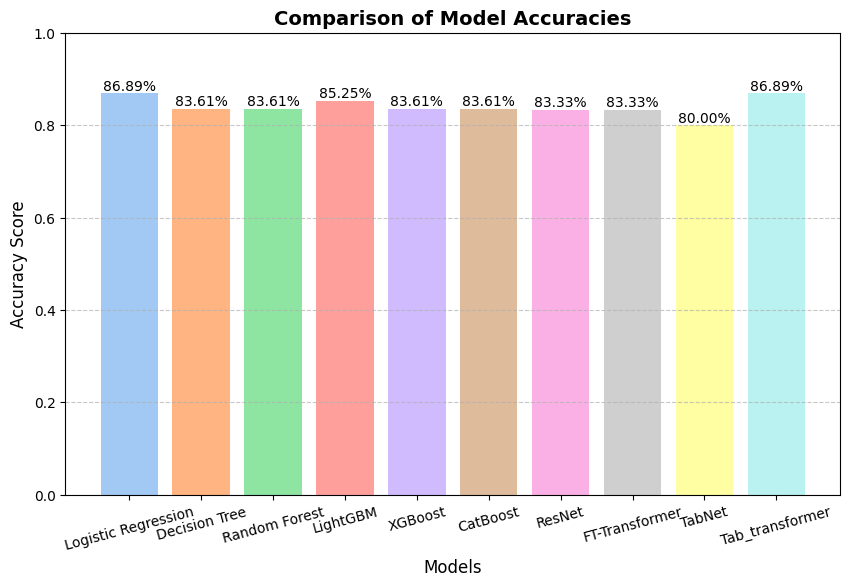

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()